In [1]:
import os
import cv2
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

from keras.utils import to_categorical
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.models import Sequential

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.models import load_model

####  Buscamos las configuraciones de nuestro modelo

In [2]:
test_images = [cv2.imread(file) for file in tqdm(glob.glob("./data/testing_images/*.jpg"))]

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 46.76it/s]


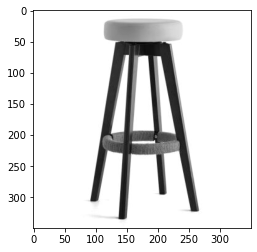

In [3]:
ts_img = test_images[1]
ts_img = cv2.cvtColor(ts_img,cv2.COLOR_BGR2RGB)
ts_img = cv2.cvtColor(ts_img,cv2.COLOR_BGR2GRAY)
plt.imshow(ts_img,cmap='gray')

### Aplicamos los Umbrales simples

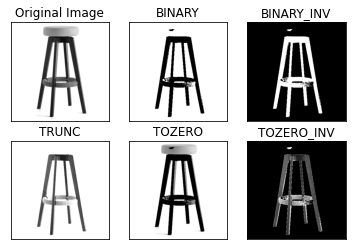

In [4]:
ret,thres_h1 = cv2.threshold(ts_img,127,255,cv2.THRESH_BINARY)
ret,thres_h2 = cv2.threshold(ts_img,127,255,cv2.THRESH_BINARY_INV)
ret,thres_h3 = cv2.threshold(ts_img,127,255,cv2.THRESH_TRUNC)
ret,thres_h4 = cv2.threshold(ts_img,127,255,cv2.THRESH_TOZERO)
ret,thres_h5 = cv2.threshold(ts_img,127,255,cv2.THRESH_TOZERO_INV)

titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
images = [ts_img, thres_h1, thres_h2, thres_h3, thres_h4, thres_h5]

for i in range(6):
    plt.subplot(2,3,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

plt.show()

### Aplicamos la binarización de Otsu

In [5]:
ret1,th1 = cv2.threshold(ts_img,127,255,cv2.THRESH_BINARY)
ret2,th2 = cv2.threshold(ts_img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

blur = cv2.GaussianBlur(ts_img,(5,5),0)
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

In [6]:
titles = ['Original Image','BINARY','BINARY + OTSU','Gauss and OTSU']
images = [ts_img, th1, th2, th3]

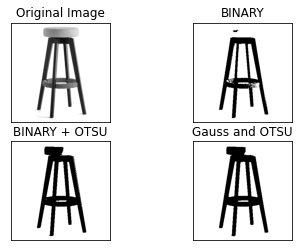

In [7]:
for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

## MODELO

In [8]:
dataimg = ['./data/training/','./data/testing/']
PATH = dataimg[0]
SIZE = 80
dataset = [] 
label = [] 

#### Principales metodos

In [9]:
def create_dataset(img_folder,dataset_img,label_class):
    
    for img in tqdm(os.listdir(img_folder)):

        target = -1
        if img[:5] == 'chair':  
            target = 0
        
        if img[:5] == 'knife':
            target = 1
            
        if img[:8] == 'saucepan':
            target = 2
            
        if target != -1:
            try:   
                #CARGAMOS LA IMAGEN
                image = cv2.imread(img_folder+img)
                
                #CAMBIAMOS EL FORMATO A RGB
                image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
                
                #CONVERTIOMS A ESCALA DE GRICES
                image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
                
                
                #SUAVIZAMOS LA IMAGEN
                blur = cv2.GaussianBlur(image,(5,5),0)
                
                #BINARIZAMOS - OTSU
                ret,image = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
                
                
                #BINARIZAMOS - BINARY
                #ret,image = cv2.threshold(blur,127,255,cv2.THRESH_BINARY)
                
                #CAMBIAMOS EL TAMAÑO
                new_array = cv2.resize(image, (SIZE, SIZE)) 
                
                #AGREGAMOS AL DATASET
                dataset_img.append(new_array) 
                label_class.append(target)
            except Exception:
                pass 

### Base de datos

In [10]:
create_dataset(PATH,dataset,label)

100%|██████████████████████████████████████████████████████████████████████████████| 3456/3456 [00:40<00:00, 86.05it/s]


In [11]:
df = np.array(dataset).reshape(-1, SIZE, SIZE)
df = df.reshape(df.shape[0], df.shape[1], df.shape[2], 1)

#### Datos de entrenamiento y prueba

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df,to_categorical(np.array(label)), test_size = 0.25, random_state = 0)

### Arquitecuta del modelo

In [13]:
model = None
model = Sequential()
model.add(Convolution2D(32, (3, 3), input_shape=(SIZE,SIZE,1), activation = 'relu', data_format='channels_last'))
model.add(MaxPooling2D(pool_size = (2, 2), data_format="channels_last"))
model.add(BatchNormalization(axis = -1))
model.add(Dropout(0.2))
model.add(Convolution2D(32, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2), data_format="channels_last"))
model.add(BatchNormalization(axis = -1))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(activation = 'relu', units=512))
model.add(BatchNormalization(axis = -1))
model.add(Dropout(0.2))
model.add(Dense(activation = 'relu', units=256))
model.add(BatchNormalization(axis = -1))
model.add(Dropout(0.2))
model.add(Dense(activation = 'sigmoid', units=3))
#model.add(Dense(activation = 'softmax', units=3))
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 78, 78, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 39, 39, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 39, 39, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 39, 39, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 37, 37, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 18, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 18, 18, 32)        1

### Entrenamiento del modelo

In [11]:
history = model.fit(np.array(X_train),
                    y_train, 
                    batch_size = 64, 
                    verbose = 1, 
                    epochs = 15,  
                    validation_split = 0.1,
                    shuffle = False)

Epoch 1/15
37/37 [==============================] - 16s 414ms/step - loss: 0.9226 - accuracy: 0.7093 - val_loss: 28.2619 - val_accuracy: 0.2692
Epoch 2/15
37/37 [==============================] - 14s 382ms/step - loss: 0.2554 - accuracy: 0.9145 - val_loss: 8.1851 - val_accuracy: 0.3269
Epoch 3/15
37/37 [==============================] - 15s 404ms/step - loss: 0.0938 - accuracy: 0.9696 - val_loss: 2.7685 - val_accuracy: 0.5308
Epoch 4/15
37/37 [==============================] - 15s 404ms/step - loss: 0.0495 - accuracy: 0.9884 - val_loss: 0.7725 - val_accuracy: 0.7962
Epoch 5/15
37/37 [==============================] - 15s 413ms/step - loss: 0.0252 - accuracy: 0.9979 - val_loss: 0.4455 - val_accuracy: 0.8615
Epoch 6/15
37/37 [==============================] - 15s 392ms/step - loss: 0.0261 - accuracy: 0.9935 - val_loss: 0.4964 - val_accuracy: 0.8538
Epoch 7/15
37/37 [==============================] - 15s 415ms/step - loss: 0.0162 - accuracy: 0.9957 - val_loss: 0.4994 - val_accuracy: 0.865

#### Resultados

In [12]:
print("Test Accuracy: {:.2f}%".format(model.evaluate(np.array(X_test), np.array(y_test))[1]*100))

27/27 [==============================] - 1s 48ms/step - loss: 0.4962 - accuracy: 0.8854
Test Accuracy: 88.54%


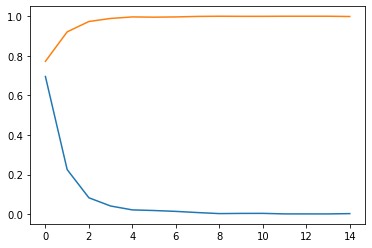

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])

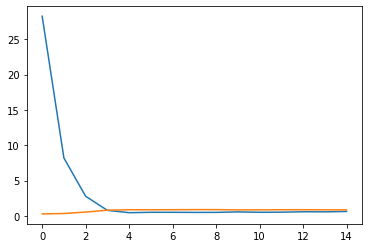

In [14]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_accuracy'])

#### matriz de confusion

In [15]:
prediction = model.predict(np.array(X_test))
y_test_matrix = [np.argmax(t) for t in y_test]
y_prediction_matrix = [np.argmax(t) for t in prediction]
confusion = confusion_matrix(y_test_matrix,y_prediction_matrix)

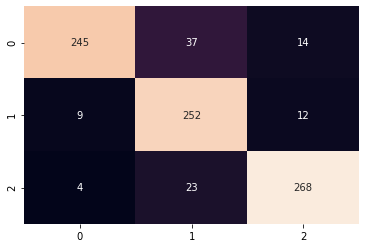

In [16]:
sns.heatmap(confusion,annot=True,fmt="d",cbar=False)
plt.show()

#### Guardamos el modelo

In [19]:
# model.save('dataset_model_binary.h5')

#### Cargamos el modelo

In [14]:
modelo_tr = load_model('dataset_model_binary.h5')

#### Prueba a una imagen individual

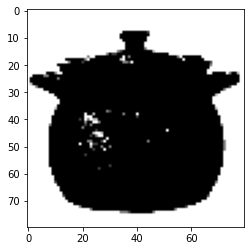

In [15]:
x = 166
plt.imshow(X_test[x],cmap='gray')

In [16]:
pred_individual = modelo_tr.predict(np.expand_dims(X_test[x],axis = 0))
print(pred_individual)
np.round(pred_individual,2)

[[6.5878034e-04 2.4575204e-02 9.9727845e-01]]


array([[0.  , 0.02, 1.  ]], dtype=float32)

### Problemas de clasificacion con imagenes de fonodo no controlado

#### Metodos

In [102]:
def GrabCut(img_intput, x_r,y_d,x_r2,y_d2):
    img = img_intput
    mask = np.zeros(img.shape[:2],np.uint8)
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)

    rect = (x_r,y_d,x_r2,y_d2)
    cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)

    mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    img = img*mask2[:,:,np.newaxis]

    plt.imshow(img),plt.colorbar(),plt.show()
    
    return img


def setColorImg(img,x_r,y_d,x_r2,y_d2,dim,val):
    img_set = img
    for i in range(y_d2):
        i+=y_d
        for j in range(x_r2):
            j+=x_r
            img_set[i,j,dim] = val
    return img_set



def showImg(img):
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    
def individualPrediction(model,img):
    pre_ind = model.predict(np.expand_dims(img,axis = 0))
 
    print(f'chair    : {pre_ind[0][0]}%')
    print(f'knife    : {pre_ind[0][1]}%')
    print(f'saucepan : {pre_ind[0][2]}%',end='\n\n')
    #print(pre_ind)
    
def whiteBackground(img_input):
    img = img_input
    img[np.where((img == [0,0,0]).all(axis=2))]=[255,255,255]
    plt.imshow(img)
    return img


def histogram_color(img,c):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    hist = cv2.calcHist([img],[c],None,[256],[0,256])
    plt.plot(hist)
    
def histogramAllColor(img):
    colors = ('b','g','r')
    for i,c in enumerate(colors):
        hist = cv2.calcHist([img],[i],None,[256],[0,256])
        plt.plot(hist,color=c)

In [87]:
def Averaging(img,d):
    blur = cv2.blur(img,(d,d))
    
    plt.subplot(121),plt.imshow(img),plt.title('Original')
    plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(blur),plt.title('Blurred')
    plt.xticks([]), plt.yticks([])
    plt.show()
    return blur

def GaussianFiltering(img,d):
    try:
        blur = cv2.GaussianBlur(img,(d,d),0)
        plt.subplot(121),plt.imshow(img),plt.title('Original')
        plt.xticks([]), plt.yticks([])
        plt.subplot(122),plt.imshow(blur),plt.title('Blurred')
        plt.xticks([]), plt.yticks([])
        plt.show()
        
        return blur
    except:
        print('la dimension del kernel debe ser con numeros impares')

def MedianFiltering(img,d):
    median = cv2.medianBlur(img,d)
    plt.subplot(121),plt.imshow(img),plt.title('Original')
    plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(median),plt.title('Blurred')
    plt.xticks([]), plt.yticks([])
    plt.show()
    return median


#----------------------------------------------

def resShapeConv(img):
    img_res = img
    return np.array(img_res).reshape( SIZE, SIZE,1)


def generateImageGray(img):
    ts_img = test_images[img]
    ts_img = cv2.cvtColor(ts_img,cv2.COLOR_BGR2RGB)
    ts_img = cv2.cvtColor(ts_img,cv2.COLOR_BGR2GRAY)
    plt.imshow(ts_img,cmap='gray')
    plt.figure()
    ts_img = cv2.resize(ts_img, (SIZE, SIZE)) 
    plt.imshow(ts_img,cmap='gray')
    #ts_img = resShapeConv(ts_img)
    
    return ts_img


def predictImg(model_p,img):
    pred_individual = modelo_tr.predict(np.expand_dims(img,axis = 0))
    print(pred_individual)
    np.round(pred_individual,2)
    

### problema #1

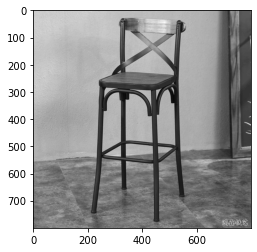

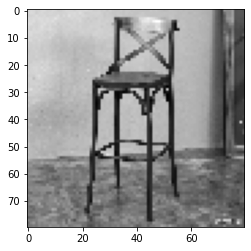

In [111]:
p1_img = generateImageGray(3)

In [112]:
p1_img.shape

(80, 80)

In [113]:
predictImg(modelo_tr,resShapeConv(p1_img))

[[0.74976134 0.99127173 0.00368273]]


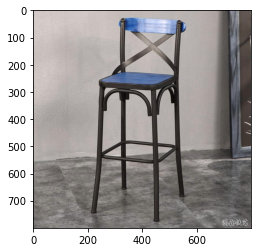

In [114]:
plt.imshow(test_images[3])

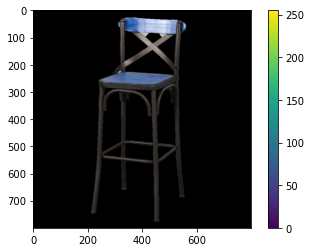

In [115]:
cut_img = GrabCut(test_images[3],200,20,370,780)

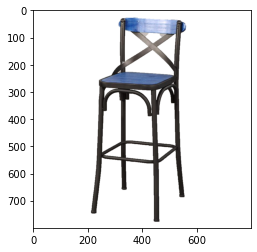

In [116]:
img_Bwhite = whiteBackground(cut_img)

In [117]:
img_Bwhite = cv2.cvtColor(img_Bwhite,cv2.COLOR_BGR2GRAY)

In [118]:
blur = cv2.GaussianBlur(img_Bwhite,(5,5),0)
ret3,th_44 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

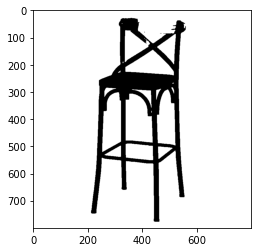

In [119]:
plt.imshow(th_44,cmap="gray")

In [120]:
th_44 = cv2.resize(th_44, (SIZE, SIZE)) 

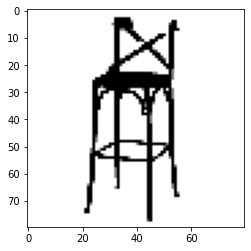

In [121]:
plt.imshow(th_44,cmap="gray")

In [122]:
predictImg(modelo_tr,resShapeConv(th_44))

[[0.9999989  0.001252   0.00602949]]
